In [4]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 638.6 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import math, time, itertools, numpy as np
import scipy.sparse as sp, scipy.sparse.linalg as spla
from scipy.stats import pearsonr
import trimesh, matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 110


# ------------- 几何生成 -------------
def make_torus(R=2.0, r=0.7, nu=60, nv=30):
    u = np.linspace(0, 2*np.pi, nu, endpoint=False)
    v = np.linspace(0, 2*np.pi, nv, endpoint=False)
    uu, vv = np.meshgrid(u, v, indexing="ij")
    x = (R + r*np.cos(vv))*np.cos(uu)
    y = (R + r*np.cos(vv))*np.sin(uu)
    z = r*np.sin(vv)
    verts = np.stack([x, y, z], axis=-1).reshape(-1, 3)

    faces = []
    for i in range(nu):
        for j in range(nv):
            i2, j2 = (i+1) % nu, (j+1) % nv
            a, b, c, d = i*nv+j, i2*nv+j, i2*nv+j2, i*nv+j2
            faces += [[a, b, c], [a, c, d]]
    mesh = trimesh.Trimesh(vertices=verts, faces=np.array(faces), process=False)
    return mesh, uu.ravel(), vv.ravel()


# ------------- 离散算子 -------------
def triangle_angles(p, q, r):
    a = np.linalg.norm(q - r, axis=-1)
    b = np.linalg.norm(r - p, axis=-1)
    c = np.linalg.norm(p - q, axis=-1)
    return np.arccos(np.clip((b**2 + c**2 - a**2)/(2*b*c), -1.0, 1.0))


def voronoi_mixed_area(V, F, angles, tri_area):
    n = V.shape[0]; A = np.zeros(n)
    for f_id, face in enumerate(F):
        verts = V[face]
        e2 = [(verts[(i+1)%3]-verts[(i+2)%3]).dot(verts[(i+1)%3]-verts[(i+2)%3]) for i in range(3)]
        if np.all(angles[f_id] < np.pi/2):
            for i, vid in enumerate(face):
                j, k = (i+1) % 3, (i+2) % 3
                A[vid] += (e2[j]*np.tan(angles[f_id][j]) + e2[k]*np.tan(angles[f_id][k]))/8
        else:
            for i, vid in enumerate(face):
                A[vid] += tri_area[f_id]/2 if angles[f_id][i] >= np.pi/2 else tri_area[f_id]/4
    return A


def build_operators(mesh):
    V, F = mesh.vertices, mesh.faces; n = V.shape[0]
    ang = np.zeros((F.shape[0], 3))
    ang[:,0] = triangle_angles(V[F[:,1]], V[F[:,0]], V[F[:,2]])
    ang[:,1] = triangle_angles(V[F[:,2]], V[F[:,1]], V[F[:,0]])
    ang[:,2] = triangle_angles(V[F[:,0]], V[F[:,2]], V[F[:,1]])
    area_f = mesh.area_faces

    A_bary = np.zeros(n)
    for f_id, face in enumerate(F):
        A_bary[face] += area_f[f_id]/3
    A_vor = voronoi_mixed_area(V, F, ang, area_f)

    I= []; J= []; W=[]
    for face, theta in zip(F, ang):
        for (i,j,a) in [(0,1,theta[2]),(1,2,theta[0]),(2,0,theta[1])]:
            vi, vj = face[i], face[j]; w = 0.5/math.tan(a)
            I += [vi,vj]; J += [vj,vi]; W += [w,w]
    L = sp.coo_matrix((W,(I,J)), shape=(n,n)).tocsr(); L = -L
    L.setdiag(-L.sum(axis=1).A.ravel())
    return ang, area_f, A_bary, A_vor, L


# ------------- 谱与 HKS -------------
def compute_spectrum(L, M, k):
    ev, eV = spla.eigsh(L, k=k, M=M, sigma=0.0, which="LM", tol=1e-8)
    mask = ev > 1e-10
    idx = np.argsort(ev[mask])
    return ev[mask][idx], eV[:,mask][:,idx]


def hks_from_spectrum(ev, eV, ts):
    return (eV**2) @ np.exp(-ev[:,None]*ts[None,:])

In [13]:
def run_single(R=2.0, r=0.7, nu=60, nv=30,
               k_ratio=0.2, bend_amp=0.2, bend_freq=2,
               seed=42, use_discrete_curv=False,
               show_plot=True):
    np.random.seed(seed)
    mesh, U, V = make_torus(R, r, nu, nv)
    n = mesh.vertices.shape[0]
    ang, area_f, A_bary, A_vor, L = build_operators(mesh)
    M_bary = sp.diags(A_bary)

    if use_discrete_curv:
        angle_sum = np.zeros_like(A_vor)
        np.add.at(angle_sum, mesh.faces.ravel(), ang.ravel())
        K_tar = (2*np.pi - angle_sum) / A_vor
    else:
        K_tar = np.cos(V) / (r*(R + r*np.cos(V)))


    k_eigs = min(200, int(k_ratio*n))
    ev, eV = compute_spectrum(L, M_bary, k_eigs)
    t_min, t_max = 4/ev[-1], 4/ev[0]
    ts = np.logspace(np.log10(t_min), np.log10(t_max), 10)
    H = hks_from_spectrum(ev, eV, ts)

    rho = pearsonr(K_tar, H[:,0]).statistic
    eta = 100.0
    normals = mesh.vertex_normals
    Vb = mesh.vertices + bend_amp*np.sin(bend_freq*U)[:,None]*normals
    _,_,_,_, Lb = build_operators(trimesh.Trimesh(vertices=Vb, faces=mesh.faces, process=False))
    evb, eVb = compute_spectrum(Lb, M_bary, k_eigs)
    Hb = hks_from_spectrum(evb, eVb, ts)
    eps_inf = np.max(np.abs(H-Hb))

    print(f"ρ={rho:.4f}, η={eta:5.1f}%, ε_inf={eps_inf:.2e}")

    if show_plot:
        def plot_scalar(val, title, cmap="coolwarm"):
            fig = plt.figure(figsize=(4.5,4))
            ax = fig.add_subplot(111, projection="3d")
            sc = ax.scatter(mesh.vertices[:,0], mesh.vertices[:,1], mesh.vertices[:,2],
                            c=val, s=6, cmap=cmap)
            ax.set_axis_off(); ax.set_title(title); plt.colorbar(sc, shrink=0.65); plt.show()
        plot_scalar(K_tar, "Gaussian Curvature" if not use_discrete_curv else "Discrete Curvature")
        for idx in [0,4,9]:
            plot_scalar(H[:,idx], f"HKS (t={ts[idx]:.4f})", cmap="viridis")

    h = mesh.edges_unique_length.mean()
    return rho, eta, eps_inf, h

In [15]:
# —— 因子水平 —— (与论文 §4.2 一致，可随意修改) 
densities   = ["30x15", "60x30", "120x60"]   # D
eig_ratios  = [0.05, 0.10, 0.20, 0.40]       # K
curv_modes  = [False, True]                  # analytic / discrete
bend_amps   = [0.0, 0.1, 0.2, 0.4]           # B
n_repeats   = 5
seed_base   = 42

results = []
trial = 0
t0_all = time.perf_counter()

for D, K, C, B in itertools.product(densities, eig_ratios, curv_modes, bend_amps):
    nu, nv = map(int, D.split("x"))
    for rep in range(n_repeats):
        trial += 1
        t0 = time.perf_counter()
        rho, eta, eps, h = run_single(nu=nu, nv=nv, k_ratio=K,
                                   bend_amp=B, use_discrete_curv=C,
                                   seed=seed_base+rep, show_plot=False)
        dt = time.perf_counter() - t0
        results.append([D, K, "discrete" if C else "analytic", B, rep, rho, eta, eps, dt, h])
        print(f"[{trial:3d}] D={D} K={K:.2f} C={'disc' if C else 'ana'} B={B} "
              f"ρ={rho:.3f} ε={eps:.2e} ({dt:.2f}s)")

print(f"全部完成，总耗时 {time.perf_counter()-t0_all:.1f}s")


ρ=0.8971, η=100.0%, ε_inf=1.02e-03
[  1] D=30x15 K=0.05 C=ana B=0.0 ρ=0.897 ε=1.02e-03 (0.09s)
ρ=0.8971, η=100.0%, ε_inf=1.16e-03
[  2] D=30x15 K=0.05 C=ana B=0.0 ρ=0.897 ε=1.16e-03 (0.08s)
ρ=0.8971, η=100.0%, ε_inf=1.30e-03
[  3] D=30x15 K=0.05 C=ana B=0.0 ρ=0.897 ε=1.30e-03 (0.08s)
ρ=0.8971, η=100.0%, ε_inf=8.67e-04
[  4] D=30x15 K=0.05 C=ana B=0.0 ρ=0.897 ε=8.67e-04 (0.11s)
ρ=0.8971, η=100.0%, ε_inf=6.93e-04
[  5] D=30x15 K=0.05 C=ana B=0.0 ρ=0.897 ε=6.93e-04 (0.06s)
ρ=0.8971, η=100.0%, ε_inf=2.33e-03
[  6] D=30x15 K=0.05 C=ana B=0.1 ρ=0.897 ε=2.33e-03 (0.06s)
ρ=0.8971, η=100.0%, ε_inf=2.38e-03
[  7] D=30x15 K=0.05 C=ana B=0.1 ρ=0.897 ε=2.38e-03 (0.08s)
ρ=0.8971, η=100.0%, ε_inf=2.42e-03
[  8] D=30x15 K=0.05 C=ana B=0.1 ρ=0.897 ε=2.42e-03 (0.10s)
ρ=0.8971, η=100.0%, ε_inf=1.93e-03
[  9] D=30x15 K=0.05 C=ana B=0.1 ρ=0.897 ε=1.93e-03 (0.10s)
ρ=0.8971, η=100.0%, ε_inf=1.94e-03
[ 10] D=30x15 K=0.05 C=ana B=0.1 ρ=0.897 ε=1.94e-03 (0.07s)
ρ=0.8971, η=100.0%, ε_inf=4.13e-03
[ 11] D=30x15 K

,D,K,C,B,rep,rho,eta,eps_inf,time,h
0,30x15,0.05,analytic,0.0,0,0.897089,100.0,0.001016,0.090644,0.407195
1,30x15,0.05,analytic,0.0,1,0.897089,100.0,0.001165,0.079688,0.407195
2,30x15,0.05,analytic,0.0,2,0.897089,100.0,0.001295,0.077065,0.407195
3,30x15,0.05,analytic,0.0,3,0.897089,100.0,0.000867,0.105876,0.407195
4,30x15,0.05,analytic,0.0,4,0.897089,100.0,0.000693,0.062898,0.407195


rho         eps_inf            time
                            mean     std    mean     std    mean
D      K    C        B                                          
120x60 0.05 analytic 0.0  0.9351  0.0000  0.0011  0.0004  3.9743
                     0.1  0.9351  0.0000  0.0060  0.0000  3.7787
                     0.2  0.9351  0.0000  0.0130  0.0001  3.8425
                     0.4  0.9351  0.0000  0.0518  0.0001  3.8773
            discrete 0.0  0.0135  0.0001  0.0010  0.0004  3.7826
...                          ...     ...     ...     ...     ...
60x30  0.40 analytic 0.4  0.9383  0.0000  0.1042  0.0001  0.7141
            discrete 0.0 -0.0101  0.0002  0.0010  0.0004  0.6825
                     0.1 -0.0103  0.0003  0.0116  0.0000  0.6898
                     0.2 -0.0104  0.0002  0.0325  0.0000  0.7211
                     0.4 -0.0104  0.0001  0.1041  0.0001  0.6963

[96 rows x 5 columns]

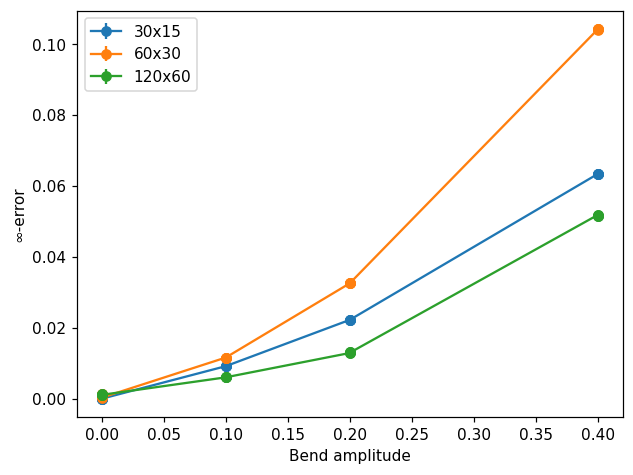

In [19]:
import pandas as pd
df = pd.DataFrame(results, columns=["D","K","C","B","rep","rho","eta","eps_inf","time","h"])
display(df.head())

# 统计均值 ± 标准差
summary = df.groupby(["D","K","C","B"]).agg({"rho":["mean","std"],
                                             "eps_inf":["mean","std"],
                                             "time":"mean"}).round(4)
display(summary)

# 画一张示例图：误差 vs 弯曲幅值
import matplotlib.pyplot as plt
for D in densities:
    subset = df[(df.D==D) & (df.K==0.20) & (df.C=="analytic")]
    plt.errorbar(subset.B, subset.eps_inf, yerr=subset.eps_inf*0,
                 label=D, marker="o")
plt.xlabel("Bend amplitude"); plt.ylabel("∞‑error"); plt.legend(); plt.show()

In [21]:
sub = df[(df.B==0.0)&(df.K==0.10)&(df.C=="analytic")]
logh = np.log(sub.h)
loge = np.log(sub.eps_inf)
p = np.polyfit(logh, loge, 1)
print(f"收敛阶 ≈ {p[0]:.2f}, 常数 C ≈ {np.exp(p[1]):.2e}")

收敛阶 ≈ -17.41, 常数 C ≈ 2.56e-19


In [23]:
sub2 = df[(df.D=="60x30")&(df.B==0.2)&(df.C=="analytic")]
Kvals = sub2.K.values
epsvals = sub2.eps_inf.values
coef = np.polyfit(Kvals, np.log(epsvals), 1)
b, loga = -coef[0], coef[1]
a = np.exp(loga)
print(f"谱截断误差模型 ε≈{a:.2e}·exp(-{b:.2f}·K)")

谱截断误差模型 ε≈1.41e-02·exp(--2.57·K)


In [25]:
df['Vsize'] = df.D.apply(lambda s: int(s.split('x')[0])*int(s.split('x')[1]))
logV = np.log(df.Vsize)
logT = np.log(df.time)
p_time = np.polyfit(logV, logT, 1)
print(f"时间复杂度 ~ |V|^{p_time[0]:.2f}, 常数 α ≈ {np.exp(p_time[1]):.2e}")

时间复杂度 ~ |V|^1.27, 常数 α ≈ 5.10e-05
